In [1]:
import csv
from scipy import sparse
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
base_path = '/bigstore/binfo/mouse/Brain/Sequencing/Allen_10X_SmartSeqTypes/'
genes = np.array(list(pd.read_csv(os.path.join(base_path,'gene_name.csv'),index_col=0)['x']))
cells = np.array(list(pd.read_csv(os.path.join(base_path,'sample_name.csv'),index_col=0)['x']))
metadata = pd.read_csv(os.path.join(base_path,'metadata.csv'),index_col=0).loc[cells]
normcounts = np.load(os.path.join(base_path,'normcounts.npy'))
metadata['counts_loc'] = range(normcounts.shape[0]) 

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
labels = np.array(list(metadata['cell_type_alias_label'].astype(str)))
unqtypes = np.unique(labels)
Gmu = np.zeros((len(genes),len(unqtypes)))
for i,ct in tqdm(enumerate(unqtypes),total=len(unqtypes)):
    ct_indexes = list(metadata[np.isin(labels,ct)]['counts_loc'])
    if len(ct_indexes)>1:
        Gmu[:,i] = np.mean(normcounts[ct_indexes,:],axis=0)
    else:
        Gmu[:,i] = normcounts[ct_indexes,:]
Gmu_max = np.max(Gmu,axis=1)
Gsep = np.array([np.nanmean(np.abs(Gmu[i,:,None]-Gmu[i,None,:])) for i in tqdm(range(Gmu.shape[0]))])

100%|██████████| 31053/31053 [00:30<00:00, 1021.97it/s]


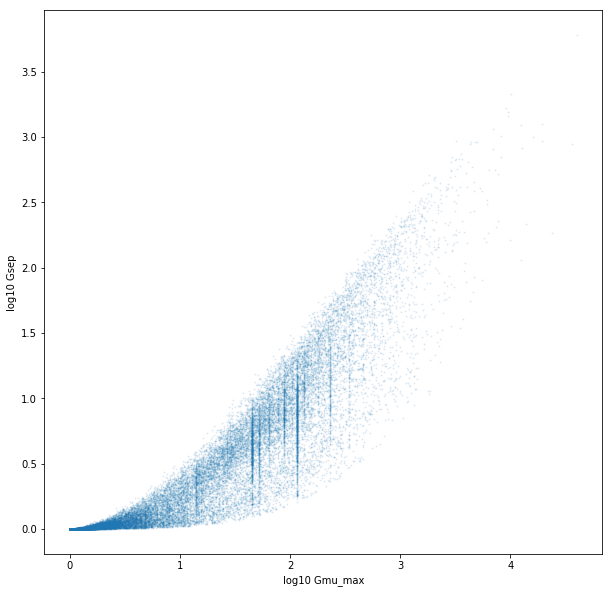

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.scatter(np.log10(Gmu_max+1),np.log10(Gsep+1),s=1,alpha=0.1)
plt.xlabel('log10 Gmu_max')
plt.ylabel('log10 Gsep')
plt.show()

In [4]:
print(np.sum((Gmu_max>10)&(Gmu_max<5000)))

15289


In [5]:
mu_mask = (Gmu_max>10)&(Gmu_max<5000)
normcounts = normcounts[:,mu_mask]
genes = genes[mu_mask]

In [6]:
# Class Balance
from tqdm import tqdm
unqtypes = [i for i in np.unique(labels) if not i=='nan']
n = 100
class_balanced = np.empty((len(unqtypes)*n,len(genes)))
balanced_labels = np.empty((len(unqtypes)*n)).astype(str)
for i,ct in tqdm(enumerate(unqtypes),total=len(unqtypes)):
    start = i*n
    end = (i+1)*n
    ct_indexes = np.where(np.array(labels)==ct)[0]
    if len(ct_indexes)>n:
        ct_indexes = np.random.choice(ct_indexes,n,replace=False)
    else:
        ct_indexes = np.random.choice(ct_indexes,n,replace=True)
    balanced_labels[start:end] = ct
    class_balanced[start:end,:] = normcounts[ct_indexes,:]

100%|██████████| 377/377 [00:57<00:00,  6.53it/s]


In [7]:
labels = np.array(list(metadata['cell_type_alias_label'].astype(str)))
idx_converter = {label:i for i,label in enumerate(np.unique(labels))}
idx_labels = np.array([idx_converter[i] for i in labels])

In [16]:
# Generate test train set 
ncells = normcounts.shape[0]
test_indexes = np.random.choice(np.array(range(ncells)),int(0.25*ncells))
train_indexes = np.array(range(ncells))[(np.isin(np.array(range(ncells)),test_indexes)==False)]
test_counts = normcounts[test_indexes,:]
train_counts = normcounts[train_indexes,:]
test_labels = labels[test_indexes]
train_labels = labels[train_indexes]
test_idx_labels = idx_labels[test_indexes]
train_idx_labels = idx_labels[train_indexes]
print('test:',test_counts.shape,'train:',train_counts.shape)

test: (273259, 15289) train: (851591, 15289)


In [8]:
import seaborn as sns
def show_confusion_matrix(unique_labels,true,predicted):
    label_converter = {label:i for i,label in enumerate(unique_labels)}
    true_converted = np.array([label_converter[i] for i in true])
    predicted_converted = np.array([label_converter[i] for i in predicted])
    confmat = np.zeros((len(unique_labels),len(unique_labels)))
    for i,it in enumerate(unique_labels):
        it_converted = label_converter[it]
        for j,jt in enumerate(unique_labels):
            jt_converted = label_converter[jt]
            confmat[i,j] = np.sum((true_converted==it_converted)&(predicted_converted==jt_converted))/np.sum((true_converted==it_converted))
    confmat = pd.DataFrame(confmat,index=unique_labels,columns=unique_labels)
    plt.figure(figsize=[10,10])
    sns.heatmap(confmat,cmap='Reds')
    plt.show()

In [9]:
"""ROC Dendrogram"""
# Load Dendrogram
def find_next_nodes(node):
    if 'leaf_attributes' in node.keys():
        A = None
        B = None
        C = node['leaf_attributes'][0]['original_label']
        H = node['leaf_attributes'][0]['height']
        Children = []
    elif 'node_attributes' in node.keys():
        try:
            A = node['children'][0]['node_attributes'][0]['original_label']
        except:
            A = node['children'][0]['leaf_attributes'][0]['original_label']
        try:
            B = node['children'][1]['node_attributes'][0]['original_label']
        except:
            B = node['children'][1]['leaf_attributes'][0]['original_label']
        C = node['node_attributes'][0]['original_label']
        H = node['node_attributes'][0]['height']
        Children = node['children']
    return A,B,C,H,Children
def dend2linkage(dend):
    A_list = []
    B_list = []
    C_list = []
    H_list = []
    Children_list = []
    A,B,C,H,Children = find_next_nodes(dend)
    A_list.append(A)
    B_list.append(B)
    C_list.append(C)
    H_list.append(H)
    Children_list.extend(Children)
    while len(Children_list)>0:
        new_Children_list = []
        for child in Children_list:
            A,B,C,H,Children = find_next_nodes(child)
            A_list.append(A)
            B_list.append(B)
            C_list.append(C)
            H_list.append(H)
            new_Children_list.extend(Children)
        Children_list = new_Children_list
    linkage = pd.DataFrame()
    linkage['A'] = A_list
    linkage['B'] = B_list
    linkage['C'] = C_list
    linkage['H'] = H_list
    linkage = linkage.sort_values('H')
    return linkage

import json
with open(os.path.join(base_path,'dend.json')) as f:
    dend = json.load(f)
linkage = dend2linkage(dend)


In [10]:
""" node by leaf matrix"""
def linkage_to_nodeleaf(linkage):
    leaves = np.array(linkage[linkage['H']==0]['C'])
    nodes = np.array(linkage[linkage['H']!=0]['C'])
    leaf_idx_converter = {leaf:i for i,leaf in enumerate(leaves)}
    node_idx_converter = {node:i for i,node in enumerate(nodes)}
    presence_matrix = np.zeros((len(leaves),len(nodes)))
    for leaf in tqdm(leaves):
        i = leaf_idx_converter[leaf]
        next_node = np.array(linkage[(linkage['A']==leaf)|(linkage['B']==leaf)]['C'])
        while next_node.shape[0]>0:
            presence_matrix[i,node_idx_converter[next_node[0]]] = 1
            next_node = np.array(linkage[(linkage['A']==next_node[0])|(linkage['B']==next_node[0])]['C'])
    node2leaf_df = pd.DataFrame(presence_matrix,index=leaves,columns=nodes)
    return node2leaf_df
node2leaf_df = linkage_to_nodeleaf(linkage)

100%|██████████| 379/379 [00:14<00:00, 25.94it/s]


In [11]:
def calculate_ROC(linkage,true,predicted):
    accuracy = []
    present_leaves = np.unique(true)
    leaves = np.array(linkage[linkage['H']==0]['C'])
    absent_leaves = leaves[np.isin(leaves,present_leaves)==False]
    temp_linkage = linkage[np.isin(np.array(linkage['C']),absent_leaves)==False]
    tp_h = np.zeros(true.shape[0])
    for h in tqdm(temp_linkage['H'].unique()):
        for ct in temp_linkage[temp_linkage['H']==h]['C']:
            if ct in leaves:
                tp_h[np.isin(true,np.array(ct))&np.isin(predicted,np.array(ct))] = 1
            else:
                node_leaves = leaves[np.array(node2leaf_df[ct])==1]
                tp_h[np.isin(true,node_leaves)&np.isin(predicted,node_leaves)] = 1
        accuracy.append(np.sum(tp_h)/tp_h.shape[0])
    return np.array(accuracy), np.array(linkage['H'].unique())
def calculate_AUC(linkage,true,predicted):
    test_a,test_h = calculate_ROC(linkage,true,predicted)
    shuffled = true.copy()
    np.random.shuffle(shuffled)
    perm_a,perm_h = calculate_ROC(linkage,true,shuffled)
    auc = np.trapz(test_a,perm_a)/np.trapz(np.ones_like(perm_a),perm_a)
    accuracy = len([i for i in range(predicted.shape[0]) if predicted[i]==true[i]])/predicted.shape[0]
    return auc,accuracy
import seaborn as sns
def show_confusion_matrix(unique_labels,true,predicted):
    label_converter = {label:i for i,label in enumerate(unique_labels)}
    true_converted = np.array([label_converter[i] for i in true])
    predicted_converted = np.array([label_converter[i] for i in predicted])
    confmat = np.zeros((len(unique_labels),len(unique_labels)))
    for i,it in enumerate(unique_labels):
        it_converted = label_converter[it]
        for j,jt in enumerate(unique_labels):
            jt_converted = label_converter[jt]
            confmat[i,j] = np.sum((true_converted==it_converted)&(predicted_converted==jt_converted))/np.sum((true_converted==it_converted))
    confmat = pd.DataFrame(confmat,index=unique_labels,columns=unique_labels)
    plt.figure(figsize=[10,10])
    sns.heatmap(confmat,cmap='Reds')
    plt.show()

100%|██████████| 298/298 [00:08<00:00, 35.76it/s]


(0.9995382555448952, 0.9870291777188329)


/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


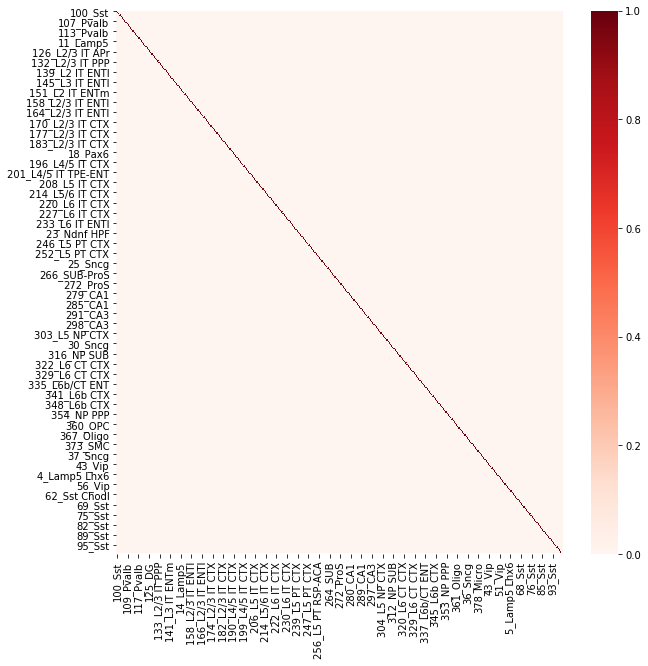

IndexError: list index out of range

In [12]:
from sklearn.feature_selection import f_regression
balanced_idx_labels = np.array([idx_converter[i] for i in balanced_labels])
out = f_regression(class_balanced,balanced_idx_labels)
temp = out[0].copy()
temp = np.nan_to_num(temp,nan=0)
temp[temp>10**10]=0
gi = temp.argsort()[-8000:]
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(class_balanced[:,gi],balanced_labels)
predicted = lda.predict(class_balanced[:,gi])
true = balanced_labels.copy()
print(calculate_AUC(linkage,true,predicted))
show_confusion_matrix(np.unique(labels),true,predicted)
show_confusion_matrix(np.unique([i.split('_')[1] for i in np.unique(labels)]),np.array([i.split('_')[1] for i in true]),np.array([i.split('_')[1] for i in predicted]))
plt.figure(figsize=[10,10])
plt.scatter(np.log10(out[0]+1),np.log10(out[1]+1))
plt.show()

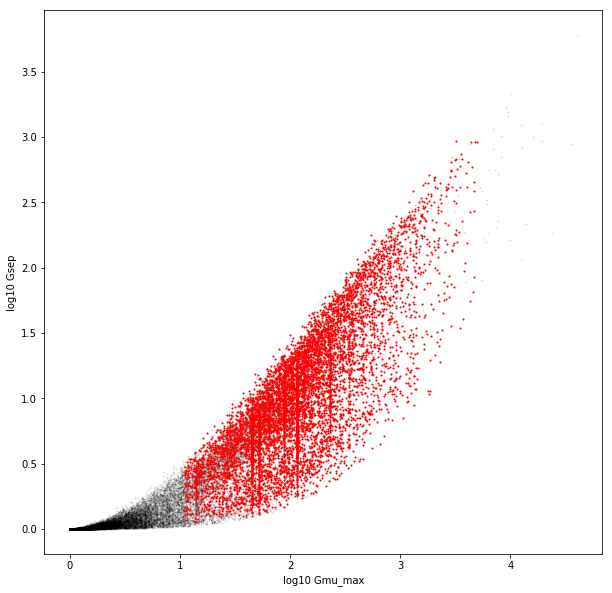

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.scatter(np.log10(Gmu_max+1),np.log10(Gsep+1),s=1,c='k',alpha=0.1)
plt.scatter(np.log10(Gmu_max[mu_mask][gi]+1),np.log10(Gsep[mu_mask][gi]+1),c='r',s=1,alpha=1)
plt.xlabel('log10 Gmu_max')
plt.ylabel('log10 Gsep')
plt.show()

In [33]:
chosen_genes = genes[mu_mask][gi]

In [34]:
from Bio import SeqIO
resource_path = '/bigstore/binfo/mouse/'
fasta_sequences = SeqIO.parse(open(os.path.join(resource_path,'mer_transcripts.fa')),'fasta')
sequences_ensemble = []
from tqdm import tqdm
for fasta in tqdm(fasta_sequences):
    sequences_ensemble.append(pd.DataFrame([str(fasta.description).split('=')[-1],str(fasta.name),str(fasta.id),str(fasta.description),len(str(fasta.seq)),str(fasta.seq)],index=['Gene name','name','id','description','length','sequence']).T)
sequences_ensemble = pd.concat(sequences_ensemble,ignore_index=True)
annotations_ensemble = pd.read_csv('/home/zach/Downloads/mouse_ensembl_annotations.csv')
filtered_sequences_ensemble = sequences_ensemble[np.isin(sequences_ensemble['Gene name'],chosen_genes)]
filtered_annotations_ensemble = annotations_ensemble[np.isin(annotations_ensemble['Transcript stable ID'],filtered_sequences_ensemble['id'])]


In [35]:
"""design new codebook with only transcripts found in sequences_ensemble"""
gname = []
gid = []
tid = []
length = []
for gene in tqdm(chosen_genes):
    gene_sequences = filtered_sequences_ensemble[np.isin(filtered_sequences_ensemble['Gene name'],gene)]
    if len(gene_sequences)==0:
        continue
    elif len(gene_sequences)==1:
        gene_tid = str(gene_sequences['id'].iloc[0])
        gene_length = int(gene_sequences['length'].iloc[0])
        gene_annotations = filtered_annotations_ensemble[np.isin(filtered_annotations_ensemble['Transcript stable ID'],gene_sequences['id'])]
        if len(gene_annotations)==0:
            gene_annotations = filtered_annotations_ensemble[np.isin(filtered_annotations_ensemble['Gene name'],gene)]
            if len(gene_annotations)==0:
                gene_gid = gene
            else:
                gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
        else:
            gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
    else:
        gene_annotations = filtered_annotations_ensemble[np.isin(filtered_annotations_ensemble['Transcript stable ID'],gene_sequences['id'])]
        if len(gene_annotations)==0:
            gene_sequences = gene_sequences.sort_values('length')
            gene_tid = str(gene_sequences['id'].iloc[0])
            gene_length = int(gene_sequences['length'].iloc[0])
            gene_annotations = filtered_annotations_ensemble[np.isin(filtered_annotations_ensemble['Gene name'],gene)]
            if len(gene_annotations)==0:
                gene_gid = gene
            else:
                gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
        elif len(gene_annotations)==1:
            gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
            gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
            gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
        else:
            if np.sum(gene_annotations['Transcript type']=='protein_coding')>0:
                gene_annotations = gene_annotations[gene_annotations['Transcript type']=='protein_coding']
            if len(gene_annotations)==1:
                gene_annotations = gene_annotations[gene_annotations['Transcript type']=='protein_coding']
                gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
                gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
                gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
            else:
                tsls = gene_annotations['Transcript support level (TSL)'].unique()
                for tsl in ['tsl1','tsl2','tsl3','tsl4','tsl5']:
                    if len([i for i in tsls if tsl in i])>0:
                        gene_annotations = gene_annotations[gene_annotations['Transcript support level (TSL)'].isin([i for i in tsls if tsl in i])]
                        break
                if len(gene_annotations)==1:
                    gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
                    gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
                    gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
                else:
                    if np.sum(gene_annotations['RefSeq mRNA ID'].astype(str)!='nan')>1:
                        gene_annotations = gene_annotations[gene_annotations['RefSeq mRNA ID'].astype(str)!='nan']
                    if len(gene_annotations)==1:
                        gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
                        gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
                        gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
                    else:
                        gene_annotations = gene_annotations.sort_values('Transcript length (including UTRs and CDS)')
                        gene_tid = str(gene_annotations['Transcript stable ID'].iloc[0])
                        gene_length = int(gene_annotations['Transcript length (including UTRs and CDS)'].iloc[0])
                        gene_gid = str(gene_annotations['Gene stable ID'].iloc[0])
    gname.append(gene)
    tid.append(gene_tid)
    length.append(gene_length)
    gid.append(gene_gid)

100%|██████████| 300/300 [00:02<00:00, 138.74it/s]


In [36]:
tid_df = pd.DataFrame(gname,columns=['gname'])
tid_df['tid'] = tid
tid_df['gid'] = gid
tid_df['length'] = length
tid_df

,gname,tid,gid,length
0,Hcrtr2,ENSMUST00000184757,ENSMUSG00000032360,2230
1,6330403K07Rik,ENSMUST00000156068,ENSMUSG00000018451,1494
2,Ptprn2,ENSMUST00000070733,ENSMUSG00000056553,3201
3,Gnal,ENSMUST00000076605,ENSMUSG00000024524,3470
4,Igsf9b,ENSMUST00000115247,ENSMUSG00000034275,2857
5,Ywhag,ENSMUST00000055808,ENSMUSG00000051391,3520
6,Kcnj6,ENSMUST00000095873,ENSMUSG00000043301,2362
7,St8sia3,ENSMUST00000025477,ENSMUSG00000056812,9747
8,Actr2,ENSMUST00000000137,ENSMUSG00000020152,3631
9,Thy1,ENSMUST00000215809,ENSMUSG00000032011,685


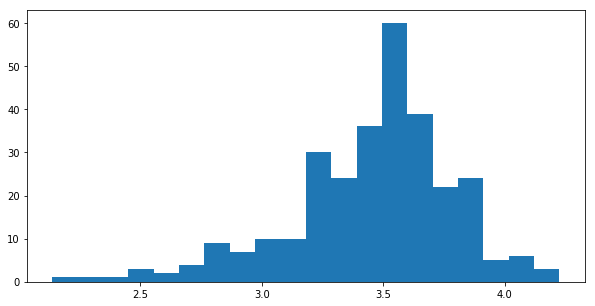

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,5])
plt.hist(np.log10(length),bins=20)
plt.show()

In [39]:
codebook = pd.DataFrame(gname,columns=['Gene'])
codebook['Transcript_ID'] = tid
codebook['Barcode'] = '1111'.zfill(18)
codebook.head()

,Gene,Transcript_ID,Barcode
0,Hcrtr2,ENSMUST00000184757,000000000000001111
1,6330403K07Rik,ENSMUST00000156068,000000000000001111
2,Ptprn2,ENSMUST00000070733,000000000000001111
3,Gnal,ENSMUST00000076605,000000000000001111
4,Igsf9b,ENSMUST00000115247,000000000000001111


In [40]:
f = '/bigstore/binfo/mouse/disulfide_readouts.fasta'
from Bio import SeqIO
readout_names = []
with open(f) as fasta_file:  # Will close handle cleanly
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        readout_names.append(seq_record.name)
print(readout_names)

def write_codebook(rows, fname, readout_names, codebook_style = '148MHD4'):
    with open(fname, 'w') as f:
        f.write('version'+','+str(1)+'\n')
        f.write('codebook_name'+','+codebook_style+'\n')
        f.write('bit_names,'+','.join(readout_names)+'\n')
        f.write('name, id, barcode\n')
        for row in rows:
            f.write(','.join([str(row[0]), str(row[1]), str(row[2])+'\n']))
# Generate Codebook
row_tuples = []

for idx, row in codebook.iterrows():
    if len(row['Transcript_ID'].split('.')[0])>0:
#         row_tuples.append((row['Gene'], row['Transcript_ID'].split('-')[1].split('.')[0], str('111000000000000001').zfill(18)))
        row_tuples.append((row['Gene'], row['Transcript_ID'], str(row['Barcode']).zfill(18)))
if not os.path.exists('/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH'):
    os.mkdir('/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH')
write_codebook(row_tuples, '/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH/DRedFISH_Validation_Codebook_V1.txt', readout_names)
row_tuples

['RS0095', 'RS0109', 'RS0175', 'RS0237', 'RS0307', 'RS0332', 'RS0384', 'RS0406', 'RS0451', 'RS0468', 'RS0548', 'RS64.0', 'RS156.0', 'RS278.0', 'RS313.0', 'RS643.0', 'RS740.0', 'RS810.0']


[('Hcrtr2', 'ENSMUST00000184757', '000000000000001111'),
 ('6330403K07Rik', 'ENSMUST00000156068', '000000000000001111'),
 ('Ptprn2', 'ENSMUST00000070733', '000000000000001111'),
 ('Gnal', 'ENSMUST00000076605', '000000000000001111'),
 ('Igsf9b', 'ENSMUST00000115247', '000000000000001111'),
 ('Ywhag', 'ENSMUST00000055808', '000000000000001111'),
 ('Kcnj6', 'ENSMUST00000095873', '000000000000001111'),
 ('St8sia3', 'ENSMUST00000025477', '000000000000001111'),
 ('Actr2', 'ENSMUST00000000137', '000000000000001111'),
 ('Thy1', 'ENSMUST00000215809', '000000000000001111'),
 ('Itm2c', 'ENSMUST00000027425', '000000000000001111'),
 ('Dtnbp1', 'ENSMUST00000072329', '000000000000001111'),
 ('Rab6b', 'ENSMUST00000035155', '000000000000001111'),
 ('Chst8', 'ENSMUST00000078686', '000000000000001111'),
 ('Rpp25', 'ENSMUST00000080514', '000000000000001111'),
 ('Vamp2', 'ENSMUST00000021273', '000000000000001111'),
 ('Clstn3', 'ENSMUST00000112523', '000000000000001111'),
 ('Efr3b', 'ENSMUST00000218166', '0

In [41]:
# Parse Fasta
f = '/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH/Validation_V1/DRedFISH_Validation_possible_oligos.fasta'
from Bio import SeqIO
with open(f) as fasta_file:  # Will close handle cleanly
    gene = []
    tid = []
    seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        name = seq_record.description.split(' ')
        seqs.append(str(seq_record.seq))
#         for i in name:
#             if 'ENS' in i:
#                 gene.append(i.split('_')[0])
#                 gid.append(i.split('_')[2])
        des = ''
        for i in seq_record.description.split(' '):
            if len(i)>len(des):
                des=i
        gene.append(des.split('__')[0])
        tid.append(des.split('__')[1])
fasta = pd.DataFrame(columns = ['gene','transcript_ID','sequence'])
fasta['gene'] = gene
fasta['transcript_ID'] = tid
fasta['sequence'] = seqs
fasta

,gene,transcript_ID,sequence
0,Hcrtr2,ENSMUST00000184757,GAGTGTGTGTTAAGGTAGGTAGGAGTAGGTTGATGTGTAGTATCAG...
1,Hcrtr2,ENSMUST00000184757,GGAGTAGGTTGATGTGTAGTAGCACTGTTGGCATATACAAGCCAAT...
2,Hcrtr2,ENSMUST00000184757,GGAGTAGGTTGATGTGTAGTAGAGTGTGTGTTAAGGTAGGTATGAG...
3,Hcrtr2,ENSMUST00000184757,GAGTGTGTGTTAAGGTAGGTAATAAGACACAGAGGTGCCATGTATG...
4,Hcrtr2,ENSMUST00000184757,GGAGTAGGTTGATGTGTAGTACACGTGCTCTGAGAGTTTTGATACA...
5,Hcrtr2,ENSMUST00000184757,GGTTAGTAGGTTGTGGTGTTAGAGTGTGTGTTAAGGTAGGTAGAGG...
6,Hcrtr2,ENSMUST00000184757,GTATAAGGTGATTGGTGGTGATTCCTGAGCCAATGCCTCCAGAGCC...
7,Hcrtr2,ENSMUST00000184757,GTATAAGGTGATTGGTGGTGACACTCCATGACAATGGCTTGAGGAA...
8,Hcrtr2,ENSMUST00000184757,GGTTAGTAGGTTGTGGTGTTAGGGAGCATGCTGCTGCACTCCATGA...
9,Hcrtr2,ENSMUST00000184757,GGTTAGTAGGTTGTGGTGTTATTTTCCTTCGTGCTCGGATCTGCTT...


In [78]:
from collections import Counter
thresh = 116
passed = [gene for gene,cc in Counter(fasta['gene']).items() if cc>thresh]
failed = [gene for gene,cc in Counter(fasta['gene']).items() if cc<=thresh]
print(len(passed),len(failed))

169 127


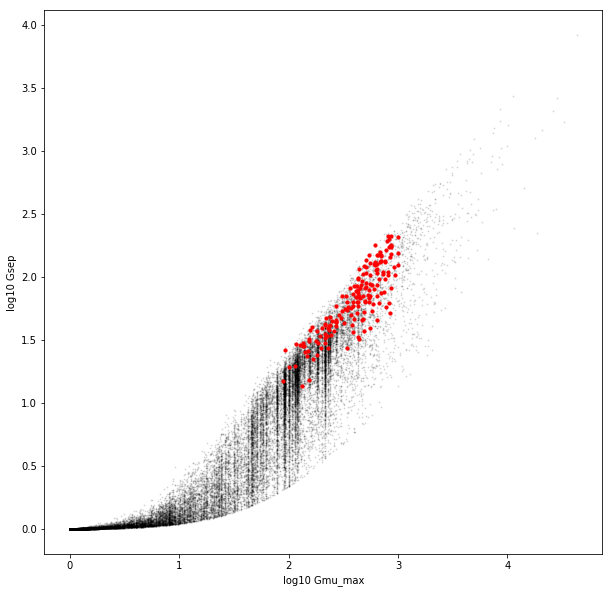

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.scatter(np.log10(Gmu_max+1),np.log10(Gsep+1),s=1,c='k',alpha=0.1)
plt.scatter(np.log10(Gmu_max[np.isin(genes,passed)]+1),np.log10(Gsep[np.isin(genes,passed)]+1),c='r',s=10,alpha=1)
plt.xlabel('log10 Gmu_max')
plt.ylabel('log10 Gsep')
plt.show()

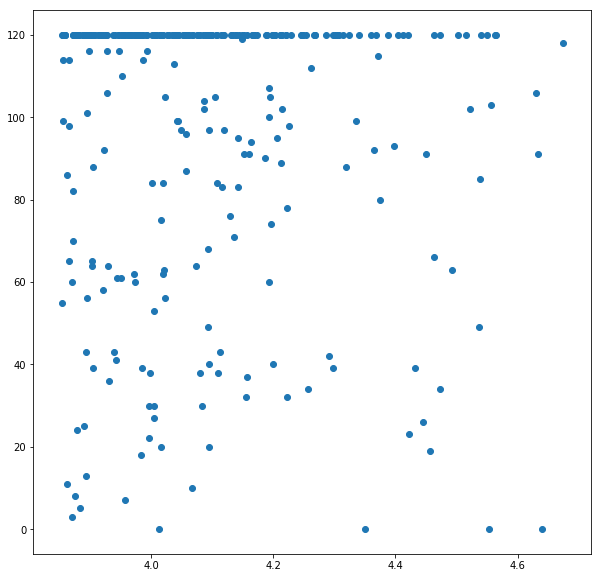

In [79]:
n_probes = np.empty(len(chosen_genes))
n_probes_dict = Counter(fasta['gene'])
for i,gene in enumerate(chosen_genes):
    n_probes[i] = n_probes_dict[gene]
plt.figure(figsize=[10,10])
plt.scatter(np.log10(out[0][np.isin(filtered_genes,chosen_genes)]),n_probes)
plt.show()

100%|██████████| 298/298 [00:04<00:00, 68.27it/s] 
/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


(0.9851158759769929, 0.910622029344906)


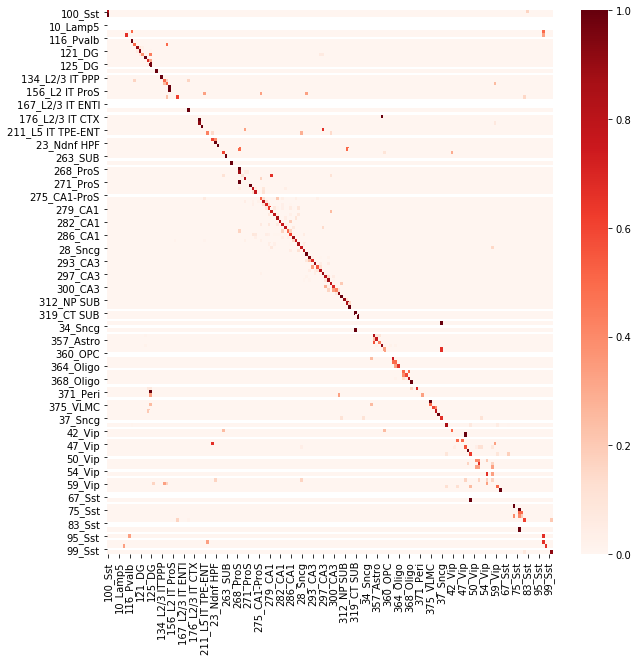

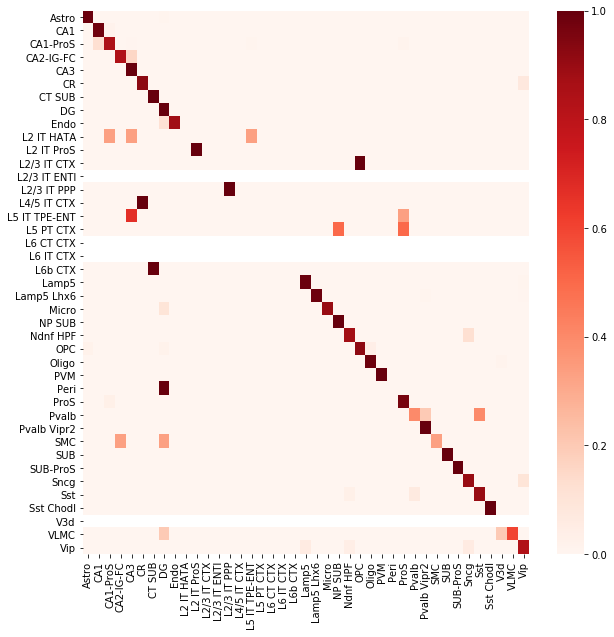

In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(train_counts[:,np.isin(filtered_genes,chosen_genes)],train_labels)
predicted = lda.predict(test_counts[:,np.isin(filtered_genes,chosen_genes)])
true = test_labels.copy()
print(calculate_AUC(linkage,true,predicted))
show_confusion_matrix(np.unique(labels),true,predicted)
show_confusion_matrix(np.unique([i.split('_')[1] for i in np.unique(labels)]),np.array([i.split('_')[1] for i in true]),np.array([i.split('_')[1] for i in predicted]))

100%|██████████| 298/298 [00:04<00:00, 67.57it/s] 
/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


(0.9814782038821057, 0.8933147344492663)


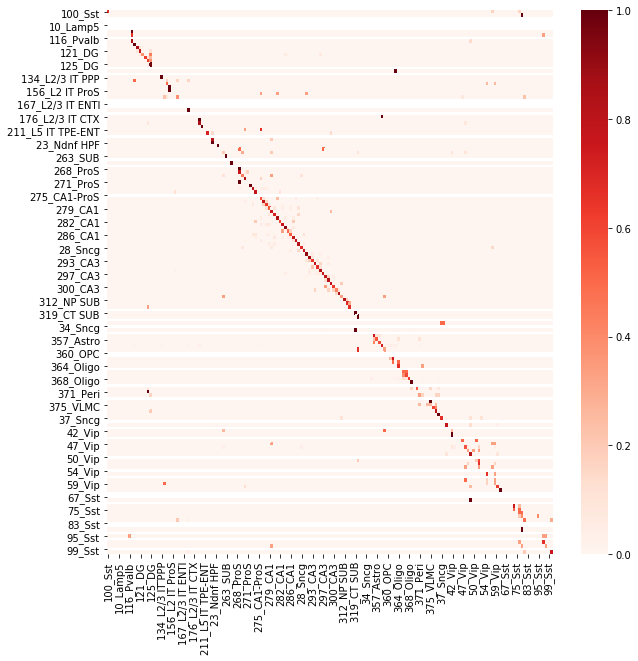

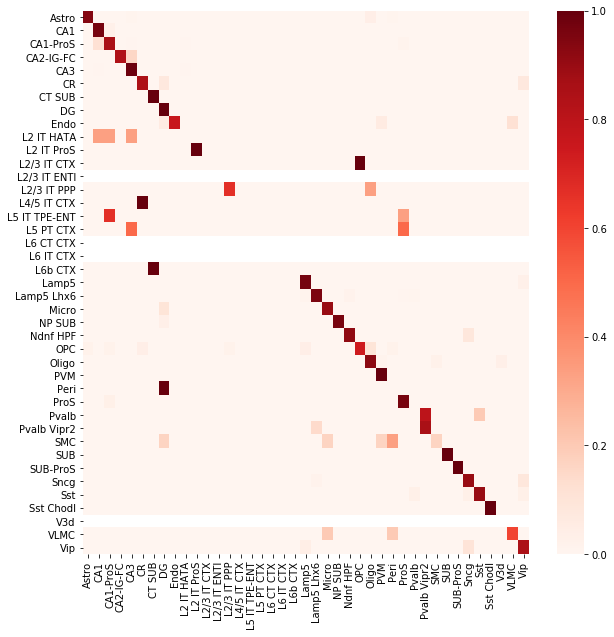

In [80]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(train_counts[:,np.isin(filtered_genes,passed)],train_labels)
predicted = lda.predict(test_counts[:,np.isin(filtered_genes,passed)])
true = test_labels.copy()
print(calculate_AUC(linkage,true,predicted))
show_confusion_matrix(np.unique(labels),true,predicted)
show_confusion_matrix(np.unique([i.split('_')[1] for i in np.unique(labels)]),np.array([i.split('_')[1] for i in true]),np.array([i.split('_')[1] for i in predicted]))

In [ ]:
"""Assign genes to barcode"""

In [82]:
base_pth = '/home/zach/PythonRepos/PySpots/hybescope_config/'
def load_codebook(fname):
    barcodes = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            bc = map(int, line.strip().split(','))
            barcodes.append(list(bc))
    return np.array(barcodes)
barcodes = load_codebook(os.path.join(base_pth,'MHD4_18bit_187cwords.csv'))

In [191]:
# Append blanks to match barcode
passed_Gmu = Gmu[np.isin(genes,passed),:]
type_expression_matrix = np.zeros((barcodes.shape[0],passed_Gmu.shape[1]))
type_expression_matrix[0:passed_Gmu.shape[0],0:passed_Gmu.shape[1]] = passed_Gmu
probed_genes = np.zeros(barcodes.shape[0]).astype(str)
probed_genes[0:len(passed)] = np.array(passed)
probed_genes[len(passed):] = np.array(['blank'+str(i) for i in range(probed_genes.shape[0]-len(passed))])

100%|██████████| 100000/100000 [03:09<00:00, 528.45it/s]


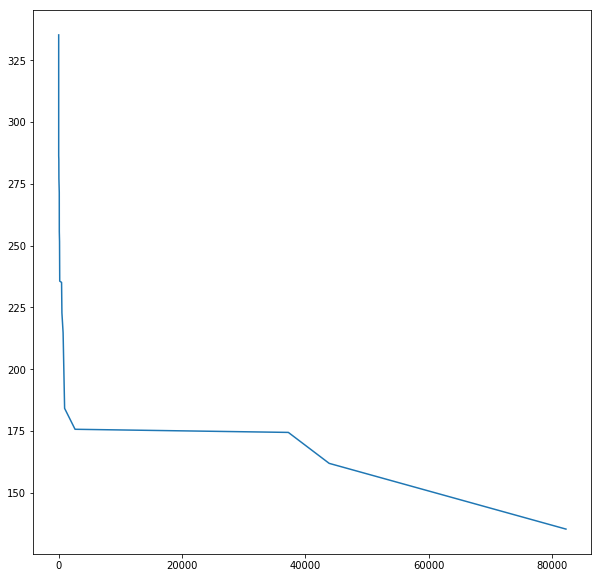

In [175]:
""" Chose barcode assignment that minimizes difference between bits"""
barcode_order = list(range(barcodes.shape[0]))
new_barcode_order = barcode_order.copy()
std = 10**10
x = []
y = []
for i in tqdm(range(10**5)):
    np.random.shuffle(new_barcode_order)
    ordered_barcodes = barcodes[new_barcode_order,:]
    new_std = np.std(np.mean(np.sum(type_expression_matrix[:,None,:]*ordered_barcodes[:,:,None],axis=0),axis=1))
    if new_std<std:
        std = new_std
        barcode_order = new_barcode_order.copy()
        x.append(i)
        y.append(std)
plt.figure(figsize=[10,10])
plt.plot(x,y)
plt.show()

In [176]:
np.std(np.sum(type_expression_matrix[:,None,:]*ordered_barcodes[:,:,None],axis=0),axis=1)

array([667.58200843, 747.67284627, 721.25079702, 791.98704544,
       954.54663761, 856.11546173, 776.76449839, 634.75048149,
       976.24746805, 794.91270152, 808.07492475, 788.47733372,
       986.06524731, 853.95304686, 878.982536  , 753.65643453,
       972.93044767, 943.60218854])

In [177]:
ordered_barcodes = barcodes[barcode_order,:]

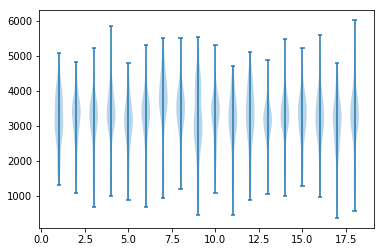

In [192]:
ct_means = np.sum(type_expression_matrix[:,None,:]*ordered_barcodes[:,:,None],axis=0)
plt.violinplot(ct_means.T)
plt.show()

In [178]:
np.mean(np.sum(type_expression_matrix[:,None,:]*ordered_barcodes[:,:,None],axis=0),axis=1)

array([3161.81555826, 3179.85148088, 3067.13526936, 3206.72401266,
       3041.6283611 , 3155.27432847, 3579.59398813, 3376.68451576,
       3112.16567112, 3203.34467964, 3072.4172957 , 3256.84127779,
       3024.21432629, 3153.89717474, 3176.58607421, 3129.195146  ,
       2969.17800364, 3241.32234633])

In [179]:
np.max(np.mean(np.sum(type_expression_matrix[:,None,:]*ordered_barcodes[:,:,None],axis=0),axis=1))

3579.5939881271206

In [180]:
np.std(np.mean(np.sum(type_expression_matrix[:,None,:]*ordered_barcodes[:,:,None],axis=0),axis=1))

135.25826762912948

In [197]:
codebook.head()

,Gene,Transcript_ID,Barcode
0,Hcrtr2,ENSMUST00000184757,000000000000001111
1,6330403K07Rik,ENSMUST00000156068,000000000000001111
2,Ptprn2,ENSMUST00000070733,000000000000001111
3,Gnal,ENSMUST00000076605,000000000000001111
4,Igsf9b,ENSMUST00000115247,000000000000001111


In [211]:
Gene = passed
tid = [codebook[np.isin(codebook['Gene'],gene)]['Transcript_ID'].iloc[0] for gene in Gene]
barcode = [''.join(i for i in ordered_barcodes[j,:].astype(str)) for j in range(len(passed))]
updated_codebook = pd.DataFrame(Gene,columns=['Gene'])
updated_codebook['Transcript_ID'] = tid
updated_codebook['Barcode'] = barcode
updated_codebook.head()

,Gene,Transcript_ID,Barcode
0,Ptprn2,ENSMUST00000070733,001000001000000011
1,Gnal,ENSMUST00000076605,000000010100000011
2,Igsf9b,ENSMUST00000115247,010000010101000000
3,Ywhag,ENSMUST00000055808,010000001000100100
4,St8sia3,ENSMUST00000025477,001000011001000000


In [212]:
f = '/bigstore/binfo/mouse/disulfide_readouts.fasta'
from Bio import SeqIO
readout_names = []
with open(f) as fasta_file:  # Will close handle cleanly
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        readout_names.append(seq_record.name)
print(readout_names)

def write_codebook(rows, fname, readout_names, codebook_style = '148MHD4'):
    with open(fname, 'w') as f:
        f.write('version'+','+str(1)+'\n')
        f.write('codebook_name'+','+codebook_style+'\n')
        f.write('bit_names,'+','.join(readout_names)+'\n')
        f.write('name, id, barcode\n')
        for row in rows:
            f.write(','.join([str(row[0]), str(row[1]), str(row[2])+'\n']))
# Generate Codebook
row_tuples = []

for idx, row in updated_codebook.iterrows():
    if len(row['Transcript_ID'].split('.')[0])>0:
#         row_tuples.append((row['Gene'], row['Transcript_ID'].split('-')[1].split('.')[0], str('111000000000000001').zfill(18)))
        row_tuples.append((row['Gene'], row['Transcript_ID'], str(row['Barcode']).zfill(18)))
if not os.path.exists('/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH'):
    os.mkdir('/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH')
write_codebook(row_tuples, '/bigstore/GeneralStorage/Zach/MERFISH/Probe_Design/results/DRedFISH/DRedFISH_Validation_Codebook_Final.txt', readout_names)
row_tuples

['RS0095', 'RS0109', 'RS0175', 'RS0237', 'RS0307', 'RS0332', 'RS0384', 'RS0406', 'RS0451', 'RS0468', 'RS0548', 'RS64.0', 'RS156.0', 'RS278.0', 'RS313.0', 'RS643.0', 'RS740.0', 'RS810.0']


[('Ptprn2', 'ENSMUST00000070733', '001000001000000011'),
 ('Gnal', 'ENSMUST00000076605', '000000010100000011'),
 ('Igsf9b', 'ENSMUST00000115247', '010000010101000000'),
 ('Ywhag', 'ENSMUST00000055808', '010000001000100100'),
 ('St8sia3', 'ENSMUST00000025477', '001000011001000000'),
 ('Rab6b', 'ENSMUST00000035155', '001010001000000100'),
 ('Clstn3', 'ENSMUST00000112523', '000100111000000000'),
 ('Efr3b', 'ENSMUST00000218166', '000001110000000010'),
 ('Atp2a2', 'ENSMUST00000177974', '100101000000100000'),
 ('Egfr', 'ENSMUST00000102884', '101000000000100100'),
 ('Bcat1', 'ENSMUST00000111742', '101000000000010010'),
 ('Timp2', 'ENSMUST00000017610', '011000001000010000'),
 ('Arhgap20', 'ENSMUST00000130405', '011101000000000000'),
 ('Cux2', 'ENSMUST00000086317', '000100100000010100'),
 ('Tanc1', 'ENSMUST00000139863', '010100001001000000'),
 ('Lpl', 'ENSMUST00000015712', '000100010001100000'),
 ('Arnt2', 'ENSMUST00000208232', '001001000100000001'),
 ('Chd5', 'ENSMUST00000164662', '00000000100

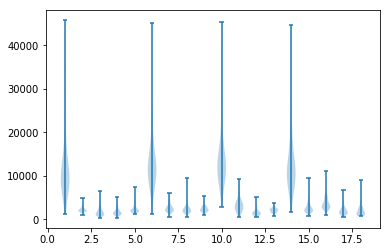

In [190]:
import importlib
cword_config = 'seqfish_config_tbi_v4'
config = importlib.import_module(cword_config)
tbi_genes = config.gids
# Append blanks to match barcode
passed_Gmu = Gmu[np.isin(genes,tbi_genes),:]
type_expression_matrix = np.zeros((barcodes.shape[0],passed_Gmu.shape[1]))
type_expression_matrix[0:passed_Gmu.shape[0],0:passed_Gmu.shape[1]] = passed_Gmu
probed_genes = np.zeros(barcodes.shape[0]).astype(str)
probed_genes[0:len(passed)] = np.array(passed)
probed_genes[len(passed):] = np.array(['blank'+str(i) for i in range(probed_genes.shape[0]-len(passed))])
ct_means = np.sum(type_expression_matrix[:,None,:]*barcodes[:,:,None],axis=0)
plt.violinplot(ct_means.T)
plt.show()